# A Gaussian-Approximation potential for Barium Titanate

The present notebook is meant to give you an overview of the main ingredients that you need to build an interatomic potential with Librascal. We will then use it in connection with i-Pi (https://github.com/cosmo-epfl/i-pi) to generate Molecular Dynamics trajectories of the system of interest. 
We will start from building a GAP model for $\text{BaTiO}_3$, a widely known ferroelectric (M. Acosta et al., https://doi.org/10.1063/1.4990046) using a training set of DFT-computed structures, calculate its learning curves to check its performance on a test set and run a short NVT simulation at $\text{T} = 10\,\text{K}$. 

The mathematical framework that we are going to use is the kernel-GAP fitting method, using both total energies and atomic forces as target properties. Basically the GAP-model total energy of a $\text{BaTiO}_3$ structure is computed using the following expression: 

\begin{equation}
                    E = E_0 + \sum_i \sum_{s=1}^M \alpha_s K(\bf{d_i} , \bf{d_s} )                   
\end{equation}

where $E_0$ represents an energy baseline (given usually by the sum of atomic self-contributions), $\bf{d_i}$ ($i = 1, \dots, N_{atoms}$) are the set of (normalized SOAP) descriptors describing an environment centred around atom $i$, $\bf{d_s}$ the set of descriptors corresponding to the environments of the sparse set (of size $M$) and K a kernel matrix that describes the similarity of two different atomic environments. In our application, the kernel is just the dot product, raised to some integer power $\zeta$: 

\begin{equation}
        K(\bf{d_i} , \bf{d_s} ) \propto \left| \bf{d_i} \cdot \bf{d_s} \right|^{\zeta}           
\end{equation}

Finally $\alpha_s$ represents the weights of each sparse environment, to be determined using Kernel-Ridge Regression (KRR).
For extensive details on the SOAP GAP-model fitting procedure and interesting physical applications, we invite the reader to refer to...(link to the chemrev Review and to our manuscript on Barium Titanate, once available). Details on the implementation in Librascal instead are given in https://cosmo-epfl.github.io/librascal/SOAP.html.

## Getting started 

In order to be able to fit a potential with Librascal (the model evaluator) and interface it with i-Pi (the MD engine) we first need to have both softwares available and correctly installed. To enable communication between them, two specific branches have been designed: 
+ the feat/librascal branch in i-Pi. 

Make sure that you git pull these branches after cloning the two github repositories.

Next step is installing Librascal using the following instructions:
+ git clone librascal
+ cd librascal
+ pip install .

(NOTE: See the top-level README for the most up-to-date installation instructions.)

## Importing all the necessary Librascal modules

Let us start from the import of all the necessary modules. This includes the basic modules of Librascal to compute: 

1) the SOAP descriptors of a structure, by means the $\bf{SphericalInvariants}$ class;

2) the kernels between a set of environments and the sparse set (the $\bf{Kernel}$ class);

3) the GAP model itsself, which is saved as an object of the $\bf{KRR}$ class. The predict method of the same class will allow us to give predictions to new unseen structures. 

NOTE: it is supposed that the input format for the training set and the test set is an ASE-extended .xyz file, which is then converted into an array of ASE Atoms objects, each one corresponding to a specific structure. Librascal uses these frames to compute the representations and to predict the properties of new structures. It is also expected that the global target properties, such as the total potential energy of the system, are reported in the header line following the ASE format, while local quantities like atomic forces are reported as additional columns of the xyz. The $\text{BaTiO}_3$ dataset contained in this same folder can be used as an example. 

In [10]:
%matplotlib inline
from matplotlib import pylab as plt

import os, sys
from ase.io import read
sys.path.insert(0,"../../../build/")

import sys
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
from tqdm import tqdm_notebook
from time import time

import json
import sympy as sym

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, sparse_points, train_gap_model
from rascal.neighbourlist import AtomsList
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score

The utility function that we write below extracts all the relevant properties from each ASE frame. This calls the $\bf{info}$ and $\bf{arrays}$ methods of the ASE.Atoms class. For more information, check the ASE documentation https://wiki.fysik.dtu.dk/ase/ase/atoms.html. In our specific case frame.info stores the information of the total energy (or possibly other global quantities), while frames.arrays the available information about the atomic quantities (atomic numbers, positions, forces). All these quantities can be accessed using specific ASE methods.

In [11]:
# Load the first N structures of the BaTiO3 dataset
N_dataset = 1000
frames = read('BaTiO3_dataset.xyz', index=':{}'.format(N_dataset))

#Additional 'global' information of a single frame
print("info : ", frames[0].info)
#Keys of the arrays dictionary
print(frames[0].arrays.keys())

info :  {'energy': -29613.169687949987}
dict_keys(['numbers', 'positions', 'forces'])


In [12]:
def extract_ref(frames,info_key='energy',array_key='zeros'):
    y,f = [], []
    for frame in frames:
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        f = np.concatenate(f)
    except:
        pass
    return y,f

## Build the GAP model

The preliminary step towards building a GAP model is defining a training and a test set. The training set is usually built by random selection of $80\%$ of the available structures, while the remaining $20\%$ will represent the test set. At this point, we also extract the distinct atomic species present in our system, define the atomic baseline energy and extract the information regarding energies and forces in the train and test set structures, which we will need later on.

IMPORTANT NOTE: in order to construct a potential that works and that does thus not blow up in the first steps of the MD simulation, we need as many input structures as we can. Depending on the level of accuracy that we want to achieve and whether we train our GAP model on total energies only or also on atomic forces, we might easily need several thousands of structures to correctly reproduce the physics of the system. 

For this tutorial case we will however use N=20, as the GAP model fitting procedure requires in general the allocation of several tens of GBs of RAM memory and an HPC system readily available, while we want this notebook to be able to run on a normal laptop to illustrate the main steps. You might check out the memory usage by using htop on a separate terminal. 

Anyway, the code snippets that you would use to fit a more accurate potential with more structures will not change, they will just be wrapped into a python script and a slurm job to be submitted to an HPC facility. Down to next paragraph we will provide an example of such a slurm job, that computes a potential with the same instructions of this notebook but trained on 800 structures ($80\%$ of the dataset size). As the peak more usage in this case reaches up to approx. 120 GB of RAM memory, make sure that you have it available on the HPC node you are using. The potential obtained in this way is available in this folder and we will load it later on for the assessment of the model performance and for the MD run.

In [13]:
# Number of structures to train the model with
n = 20

global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)

# Select randomly n structures for training the model
ids = list(range(N_dataset))
np.random.seed(10)
np.random.shuffle(ids)

train_ids = ids[:n]
frames_train = [frames[ii] for ii in ids[:n]]

In [14]:
y_train, f_train = extract_ref(frames_train,'energy', 'forces')
y,f = extract_ref(frames,'energy', 'forces')

In [15]:
# Atomic energy baseline
atom_energy_baseline = np.mean(y)/(frames[0].get_global_number_of_atoms())
energy_baseline = {np.int(species): atom_energy_baseline for species in global_species}

Now we proceed with the actual calculation of the SOAP vectors of our training set. We need to specify an hyperparameters dictionary, which Librascal uses to compute the structural features. The meaning of each single command and how to correctly set them is reported in https://cosmo-epfl.github.io/librascal/reference/python.html?highlight=soap#rascal.representations.SphericalInvariants. These hyperparameters can be used as default values, but a careful optimization of the interaction cutoff might be required in the case the material under investigation might present some mid- or long-range order. 

For the actual calculation of the SOAP features, we first create an object of the SphericalInvariants class, defined by its hyperparameters.The methods that we then need to use are $\textbf{transform()}$, which yields a second object called the $\textbf{manager}$ containing the representation, while $\textbf{get_features()}$ converts it into an $NxM$ matrix, $N$ being the number of atomic environments in the training set and M the number of features per each environment. 

NOTE: the Librascal structure manager only works if the atoms have been preliminary wrapped within the cell provided in the input file. It might however give issues whenever atoms are too close to the cell boundary, so in the case you want to model a system with periodic boundary conditions, it is common practice to displace the atoms by some non-zero vector and then wrap them back using the $\textbf{ase.wrap()}$ function.

In [16]:
# define the parameters of the spherical expansion
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=5.5, 
              max_radial=8, 
              max_angular=6, 
              gaussian_sigma_constant=0.5,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.5,
                            exponent=4
                        ),
              radial_basis="GTO",
              optimization_args=
                    dict(
                            type="Spline",                                            
                            accuracy=1.0e-05                        
                        ),
              normalize=True,
              compute_gradients=True
              )


soap = SphericalInvariants(**hypers)

The following snippet computes the descriptors and the managers for each frame, which will represent the expensive part of the calculation, in terms of memory usage.

In [17]:
managers = []
for f in frames_train:
    positions = f.get_positions()
    f.set_positions(positions+[1,1,1])
    f.wrap(eps=1e-18)

start = time()
managers = soap.transform(frames_train)
print ("Execution: ", time()-start, "s")

Execution:  4.778249502182007 s


At this point, we can define the $\textbf{sparse set}$, i.e. the set of "maximally diverse" environments that will be used to perform the Kernel Ridge Regression. We can choose the number of sparse environments in Librascal per each atomic species, by defining a dictionary containing (atomic number, number of environments) pairs. The CURFilter class then filters out the most diverse environments according to the representation that we provide as the input object and by applying the CUR decomposition.

In [19]:
# select the sparse points for the sparse kernel method with CUR on the whole training set
n_sparse = {8:240, 22:80, 56:80}
compressor = CURFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers)

The number of pseudo points selected by central atom species is: {8: 240, 22: 80, 56: 80}
Selecting species: 8
Reconstruction RMSE=1.357e-04
Selecting species: 22
Reconstruction RMSE=2.082e-04
Selecting species: 56
Reconstruction RMSE=2.200e-04


As shown in eq. $(1)$, in order to fit a GAP potential we need to compute the kernels of all the training structure descriptors and the sparse set, as well as the gradients w.r.t. the atomic positions, if we wish to fit the atomic forces. We do so by using another key structure of librascal: the $\textbf{Kernel}$ class. We first build a kernel object containing the representation (soap), which we then use to compute the sparse kernel matrix $K_{NM}$ between the training set and the sparse set and its gradients. The option "grad=(True, False)" corresponds to the calculation of the gradients of the first argument of the kernel w.r.t. to the atomic positions.

Finally, we group everything together to build the GAP model, which basically uses the kernel matrices to regress the weights $\{\alpha_s\}_{s=1}^M$ on each sparse environment. The lambdas represent the regularization parameters of the KRR (for both energies and forces), while jitter is a small parameter that enables its numerical convergence. 

The output is a KRR object, which we can save as .json file for future use. For this last bit we use the $\textbf{dump_obj}$ method (part of the io module). 

In [20]:
# set up the sparse kernel and compute the representation for the train set
zeta = 4
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

# build the KNM matrix for training with forces and energies (see train_gap_model for more details)
KNM = kernel(managers, X_sparse)
KNM_grads = kernel(managers, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_grads])
del KNM_grads
KNM_grads = []

# train a GAP model 
model = train_gap_model(kernel, managers, KNM, X_sparse, y_train, energy_baseline, 
                        grad_train=-f_train, lambdas=[1e-12, 1e-12], jitter=1e-13)

# save the model to a file in json format for future use
dump_obj('mymodel.json', model)

In [21]:
# free the memory of the training set managers, which we will not need any more in the following
managers = []

# Submitting a slurm job to compute a more accurate potential

As stated previosly, in order to compute a potential that is suitable to be run with an MD driver, you need to use as many ab-initio precomputed structures as you possibly can and a large RAM memory. Here we report a slurm job that you could use easily on an HPC facility to fit a GAP potential. The instructions that you need to run in your python script are exactly the same as the one that we have described so far (see the $\textbf{BaTiO3_IP.py}$ script). 

This will compute for you a potential trained on 800 structures and the indices corresponding to the shuffled dataset, so that we can then load both for the evaluation of the model on the test set. The output is the json file 'BaTiO3_model.json', already present by default in this folder. 

NOTE: to use the slurm magic commands within a jupyter notebook, please make sure you install the NERSC package with 

pip install git+https://github.com/NERSC/slurm-magic.git

In [22]:
load_ext slurm_magic

In [23]:
%%sbatch
#!/bin/bash

#SBATCH --nodes 1
#SBATCH --partition FatNode
#SBATCH --time 01:00:00
#SBATCH --job-name=GAP-BaTiO3
#SBATCH --mem 200000M

python3 BaTiO3_IP.py

'Submitted batch job 11716\n'

# Assessment of the model

To perform a basic assessment of the model we have fitted, we need to predict the properties (energies and forces) of a test set. In the calculation of the model that we will use from now on, we have randomly splitted the original dataset in a training set of 800 structures and a test set of 200.
So first we load the model and the indices corresponding to the shuffled dataset: the first 800 of those will correspond to the training set, the last 200 to the test set.  

In [24]:
n = 800
model = load_obj('BaTiO3_model.json')
ids = np.loadtxt('Structure_indices.txt')

In [25]:
train_ids = [np.int(i) for i in ids[:n]]
test_ids = [np.int(i) for i in ids[n:]] 

frames_train = [frames[ii] for ii in train_ids]
frames_test = [frames[ii] for ii in test_ids]

Let us now compute the predictions on the test set, using the $\textbf{predict}$ and $\textbf{predict_forces}$ methods of the KRR class. At this point we need to compute the SOAP representation of the test set structures. It is important to stress however that this will not cause any issue regarding memory usage, because all we need is the predictions, so we can compute the managers of the test set structures one by one and calculate the predictions right away. Instead for the GAP fitting we need to store ALL the structural managers of the training set to perform the regression (which causes a large RAM usage).

In [26]:
# make predictions on the test set
y_pred = []
f_pred = []

for f in tqdm_notebook(frames_test):
    positions = f.get_positions()
    f.set_positions(positions+[1,1,1])
    f.wrap(eps=1e-18)
    m = soap.transform(f)
    y_pred.append(model.predict(m))
    f_pred.append(model.predict_forces(m))

y_pred = np.array(y_pred)
f_pred = np.array(f_pred)

In [27]:
y_test, f_test = extract_ref(frames_test,'energy', 'forces')

Let us now compute the overall performance of the model. This is done by calculation of the Root-Mean-Square Error (RMSE), i.e. the standard deviation of the residuals according to the standard formula:

   \begin{equation}
       \text{RMSE} = \frac{\sqrt{(y_{\text{pred}}^{i} - y_{\text{test}}^{i})^2}}{n_{\text{test}}}
   \end{equation}
   
which we can compare to the standard deviation of the test set itsself to quantify how much the model captures the energy variations in the test set. The $\% \text{RMSE}$ of our model is about $2.5 \%$ of the training set STD, which is sufficiently accurate to run MD safely. 

Finally we plot a "correlation plot", to observe how well the predictions on the test set correlate with the reference DFT-computed energies.

In [28]:
RMSE = 0.0
for i in range(len(y_test)):
    RMSE += (y_test[i] - y_pred[i])**2

RMSE = np.sqrt(RMSE/len(y_test))
sigma_test = np.std(y_test)
print("RMSE = ", RMSE[0]*1000.0, "meV")
print("Sigma test set = ", sigma_test, " eV")
print("%RMSE = ", RMSE[0]/sigma_test*100.0, " %")

RMSE =  62.19945010044599 meV
Sigma test set =  2.466333552462597  eV
%RMSE =  2.521939907047073  %


Text(0, 0.5, 'reference energies [eV]')

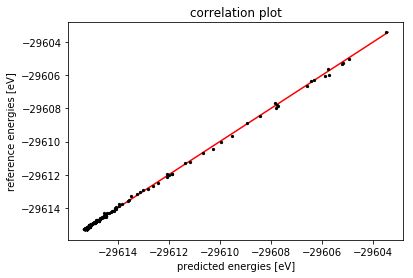

In [29]:
plt.scatter(y_test, y_pred, s=5.0, c = 'black')
lims = [
    np.min([np.min(y_pred), np.min(y_test)]),  # min of both axes
    np.max([np.max(y_pred), np.max(y_test)]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims, 'k-', zorder=0, color='red')
plt.title("correlation plot")
plt.xlabel("predicted energies [eV]")
plt.ylabel("reference energies [eV]")

In [30]:
frames = []

# MD simulations

Now we are going to use the fitted model to perform a simple NVT simulation at $\text{T} = 10\,$K using the i-Pi interface with librascal. For that we will use a Librascal python driver of the feat/ipi branch (in the \scripts folder): this will create a communication socket with i-Pi, which basically receives as input a structure and returns energies, forces and stresses by means of the $\textbf{IPICalculator}$ class of Librascal. 

The job itsself will generate a parent process (i-Pi) which contains information of the ensemble, the step needed for the time-integration, the thermostat characteristics, and all other trajectory-related infos. All these information are initially stored in an input.xml file as specified in the i-Pi documentation at https://github.com/cosmo-epfl/i-pi and given as inputs to i-Pi. The Librascal driver is then launched as a child process and exchanges information with the MD driver.  

The Librascal driver needs some input parameters, that can be given directly in the command line when the driver is called. To check the needed information, just use the --help option when calling it, as shown below.

NOTE: in what follows, it is assumed that your i-Pi and Librascal folders lie in a common directory. Check and modify the path below when defining IPI if this is not the case.

In [80]:
%%bash
RASCAL_DRIVER="../../../scripts/ipi_driver.py"

export PYTHONPATH="$PYTHONPATH../../../build/"

$RASCAL_DRIVER --help

../../../scripts/ipi_driver.py
usage: ipi_driver.py [-h] [-u] [-a ADDRESS] [-p PORT] [-m MODEL]
                     [-s STRUCT_TEMPL]

Python driver for i-PI providing energies and forces from librascal

optional arguments:
  -h, --help            show this help message and exit
  -u, --unix            Use a UNIX domain socket.
  -a ADDRESS, --address ADDRESS
                        Host name (for INET sockets) or name of the UNIX
                        domain socket to connect to.
  -p PORT, --port PORT  TCP/IP port number. Ignored when using UNIX domain
                        sockets.
  -m MODEL, --model MODEL
                        GAP model filename to be used as input to librascal
                        (.json file)
  -s STRUCT_TEMPL, --struct_templ STRUCT_TEMPL
                        Filename for an ASE-compatible Atoms object, used only
                        to initialize atom types and numbers


Now we run the MD simulation. Again we are using a slurm job, since it will take a while (around 2 hours) to compute the full trajectory (1000 steps for a total time of 2 ps), but you can also run it on your laptop. In the latter case, run only the instructions that follow the sbatch options.

Check the .xml file in this folder to quickly read the relevant information about the MD settings. Importantly, the $\text{<properties>}$ tag gives you information about the physical properties that are printed out by i-Pi. This simulation gives as output a .out file containing the time-evolution of all the relevant physical quantities, while the .xc.xyz file contains the full trajectory, which you can later visualize with VMD. The file $\textbf{BaTiO3_cubic_3x3x3.xyz}$ is both used by i-Pi as a starting configuration of the trajectory and by Librascal as a template to load information about chemical species and number of atoms per species of the system. It represents a 3x3x3 pristine cubic structure with a total of $135$ atoms.

As the simulation evolves you can plot some interesting physical properties, for instance the MD kinetic energy, the total potential energy and the pressure, and check for thermalization.

In [17]:
%%sbatch
#!/bin/bash

#SBATCH --nodes 1
#SBATCH --partition Slim
#SBATCH --time 03:00:00
#SBATCH --job-name=iPi-BaTiO3

rm /tmp/ipi_BaTiO3
export PYTHONPATH="$PYTHONPATH../../../build/"

RASCAL_DRIVER="../../../scripts/ipi_driver.py"

IPI="../../../../i-pi/bin/i-pi"

#At this point comes the MD job described previously

$IPI input.xml & sleep 5;\
$RASCAL_DRIVER -u -a BaTiO3 -m BaTiO3_model.json -s BaTiO3_cubic_3x3x3.xyz &\
wait

'Submitted batch job 11715\n'

[Text(0.5, 0, 'time [ps]')]

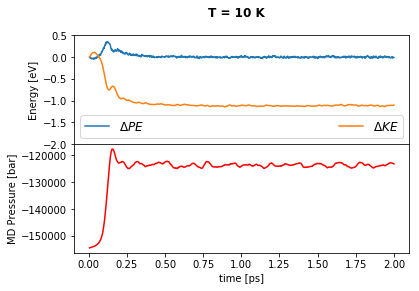

In [20]:
#Plotting the results of the simulations
f = open('10_K_BaTiO3_MD.out',"r")
lines=f.readlines()[13:]

Nframes = len(lines)
steps = np.zeros((Nframes, 1), dtype=float)
time = np.zeros((Nframes, 1), dtype=float)
KE = np.zeros((Nframes, 1), dtype=float)
PE = np.zeros((Nframes, 1), dtype=float)
Pressure = np.zeros((Nframes, 1), dtype=float)

i = 0
for x in lines: 
    steps[i] = float(x.split()[0])
    time[i] = float(x.split()[1])
    KE[i] = float(x.split()[4])
    PE[i] = float(x.split()[5])
    Pressure[i] = float(x.split()[6])
    i += 1

f, axs = plt.subplots(2, 1, sharex=True)
f.subplots_adjust(hspace=0)
f.suptitle('T = 10 K', fontweight='bold')

axs[0].plot(time, (KE - KE[0]), linewidth = 1.5, label = r'$\Delta PE$')
axs[0].plot(time, (PE - PE[0]), linewidth = 1.5, label = r'$\Delta KE$')
axs[0].set(ylabel= 'Energy [eV]')
axs[0].set_ylim(-2.0, 0.5)
axs[0].legend(ncol = 2, mode='expand', prop={'size': 12}, loc="lower center")

axs[1].plot(time, Pressure, linewidth = 1.5, color = 'red')
axs[1].set(ylabel= 'MD Pressure [bar]')
axs[1].set(xlabel= 'time [ps]')